In [190]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV, Lasso, Ridge, RidgeClassifier, SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, precision_recall_fscore_support, f1_score, r2_score 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

### MODEL SPORTS DATA

In [191]:
df_features = pd.read_csv('../data/modeling/SPORTS/feature_data_SPORTS_21205.csv', sep='|')
df_targets = pd.read_csv('../data/modeling/SPORTS/target_data_SPORTS_21205.csv', sep='|')

df_features = df_features.set_index('owner').set_index("id", append=True)

df_targets = df_targets.set_index('owner').set_index("id", append=True)

target_columns = list(df_targets.columns)
target_columns.remove('image_ntags')
target_columns

df = df_features.join(df_targets, how='inner')

df.dropna(axis=0, inplace=True)

In [211]:
df.columns

Index([u'red_bin1_nbins120', u'red_bin2_nbins120', u'red_bin3_nbins120',
       u'red_bin4_nbins120', u'red_bin5_nbins120', u'red_bin6_nbins120',
       u'red_bin7_nbins120', u'red_bin8_nbins120', u'red_bin9_nbins120',
       u'red_bin10_nbins120',
       ...
       u'user_can_buy_pro', u'user_total_views', u'image_ncomments',
       u'image_nfavs', u'image_nsets', u'image_npools', u'image_views',
       u'image_ntags', u'image_tags', u'image_views_quantile'],
      dtype='object', length=1099)

### EDA

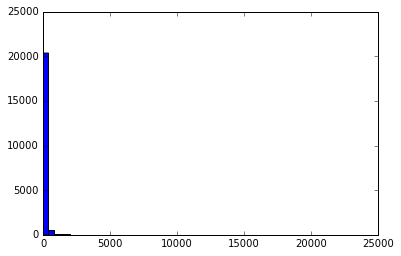

In [198]:
plt.hist(df['image_views'], bins=50)
plt.show()

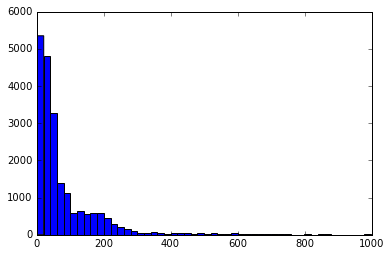

In [199]:
plt.hist(df['image_views'][df['image_views']<=1000], bins=50)
plt.show()

### Create New Quartile Targets

In [200]:
def name_quantile(x, limits):
    quantile_cats = range(1, len(limits)+1, 1)
    for cat, limit in zip(quantile_cats, limits):
        if x <= limit:
            return cat

def create_quantile_target_col(df, target_columns, col_name, n_quantiles=5):
    """
    Create a new column in the DataFrame that indicates which quantile the target column value falls into.
    
    PARAMETERS
    ----------
    df : DataFrame
    
    n_quantiles : int
        The number of bins. For 4 bins (0 to 0.25, 0.25 to 0.5, etc...), n_quantiles=4.
        
    col_name : str
    
    target_columns : list
    
    RETURNS
    -------
    df : DataFrame
    
    target_columns : list        
    """
    min_value = df[col_name].min()
    max_value = df[col_name].max()
    limits = []
    for i in range(1, n_quantiles+1):
        limits.append(df[col_name].quantile(i/float(n_quantiles)))
    
    new_col_name = col_name+"_quantile"
    target_columns.append(new_col_name)
    
    df[new_col_name] = df[col_name].apply(lambda x: name_quantile(x, limits))
    return df, target_columns

In [201]:
df, target_columns = create_quantile_target_col(df, target_columns, 'image_views', 4)

In [202]:
df_train, df_test = train_test_split(df, train_size=0.8, random_state=42)

In [203]:
def pop_columns(df, col_names):
    for i, name in enumerate(list(col_names)):
        if i == 0:
            df_dropped_cols = df.pop(name)
        else:
            df_dropped_cols = pd.concat((df_dropped_cols, df.pop(name)), axis=1)
    return df, df_dropped_cols

In [204]:
X_train, y_train = pop_columns(df_train, target_columns)
X_test, y_test = pop_columns(df_test, target_columns)

In [205]:
y_test.head(1)

,,user_is_pro,user_can_buy_pro,user_total_views,image_ncomments,image_nfavs,image_nsets,image_npools,image_views,image_tags,image_views_quantile
owner,id,,,,,,,,,,
28142675@N05,21624681988,0,0,10801,0,0,1,0,60,"[trailrunning, running, race, aae, otterbox, o...",3


In [206]:
X_columns = X_train.columns
y_columns = y_train.columns

In [207]:
scaler_mean_std = StandardScaler()
X_train = scaler_mean_std.fit_transform(X_train)
X_test = scaler_mean_std.transform(X_test)

In [208]:
X_train = pd.DataFrame(data=X_train, columns=X_columns)
X_test = pd.DataFrame(data=X_test, columns=X_columns)

### Predicting Image View Quantile (IVQ)

#### LOGISTIC MODEL

In [142]:
model_ivq_logitclassifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1,
                                               class_weight='balanced', max_iter=10000, verbose=1, warm_start=True,
                                               n_jobs=30, penalty='l2', C=1.0)

In [143]:
model_ivq_logitclassifier.fit(X_train, y_train['image_views_quantile'])

[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:   40.8s finished


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='multinomial', n_jobs=30, penalty='l2',
          random_state=1, solver='lbfgs', tol=0.0001, verbose=1,
          warm_start=True)

In [144]:
y_pred = model_ivq_logitclassifier.predict(X_test)
y_probs = model_ivq_logitclassifier.predict_proba(X_test)

In [145]:
f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='micro', sample_weight=None)

0.52110351332232963

In [148]:
f1_scores_int = []
f1_scores_no_int = []
f1_scores_cold_int = []
f1_scores_cold_no_int = []
C_values = [0.01, 0.02, 0.05, 0.1, 0.3, 0.6, 1.0, 2.0, 5.0, 10]
for i in C_values:
    model_ivq_logitclassifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1,
                                               class_weight='balanced', max_iter=10000, verbose=1, warm_start=True,
                                               n_jobs=30, penalty='l2', C=i)
    model_ivq_logitclassifier.fit(X_train, y_train['image_views_quantile'])
    y_pred = model_ivq_logitclassifier.predict(X_test)
    # y_probs = model_ivq_logitclassifier.predict_proba(X_test)
    f1_scores_int.append(f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='micro', sample_weight=None))
for i in C_values:
    model_ivq_logitclassifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1,
                                               class_weight='balanced', max_iter=10000, verbose=1, warm_start=True,
                                               n_jobs=30, penalty='l2', C=i, fit_intercept=False)
    model_ivq_logitclassifier.fit(X_train, y_train['image_views_quantile'])
    y_pred = model_ivq_logitclassifier.predict(X_test)
    # y_probs = model_ivq_logitclassifier.predict_proba(X_test)
    f1_scores_no_int.append(f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='micro', sample_weight=None))
for i in C_values:
    model_ivq_logitclassifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1,
                                               class_weight='balanced', max_iter=10000, verbose=1, warm_start=False,
                                               n_jobs=30, penalty='l2', C=i)
    model_ivq_logitclassifier.fit(X_train, y_train['image_views_quantile'])
    y_pred = model_ivq_logitclassifier.predict(X_test)
    # y_probs = model_ivq_logitclassifier.predict_proba(X_test)
    f1_scores_cold_int.append(f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='micro', sample_weight=None))
for i in C_values:
    model_ivq_logitclassifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1,
                                               class_weight='balanced', max_iter=10000, verbose=1, warm_start=False,
                                               n_jobs=30, penalty='l2', C=i,  fit_intercept=False)
    model_ivq_logitclassifier.fit(X_train, y_train['image_views_quantile'])
    y_pred = model_ivq_logitclassifier.predict(X_test)
    # y_probs = model_ivq_logitclassifier.predict_proba(X_test)
    f1_scores_cold_no_int.append(f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='micro', sample_weight=None))

[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:    6.5s finished
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:    9.7s finished
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:   16.3s finished
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:   24.3s finished
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:   35.3s finished
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:   43.6s finished
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:   48.0s finished
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:  1.3min finished
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:  1.6min finished
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:    6.5s finished
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:    9.4s finished
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:   10.6s finished
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:   15.5s finished
[Paral

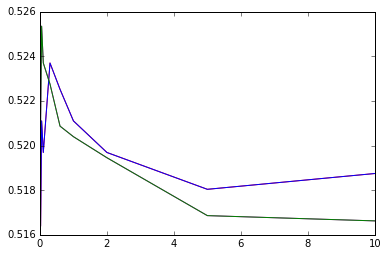

In [149]:
plt.plot(C_values, f1_scores_int, 'r')
plt.plot(C_values, f1_scores_no_int, 'm')
plt.plot(C_values, f1_scores_cold_int, 'b')
plt.plot(C_values, f1_scores_cold_no_int, 'g')

#### Random Forest Classifier

In [162]:
f1_scores_gini = None
model_ivq_randomforest = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None,
                                                min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                                max_features='auto', max_leaf_nodes=None, bootstrap=True,
                                                oob_score=False, n_jobs=30, random_state=5, verbose=1,
                                                warm_start=False, class_weight=None)
model_ivq_randomforest.fit(X_train, y_train['image_views_quantile'])
y_pred = model_ivq_randomforest.predict(X_test)
f1_scores_gini = f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='micro', sample_weight=None)

[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    3.9s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   10.0s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   18.5s
[Parallel(n_jobs=30)]: Done 1000 out of 1000 | elapsed:   24.9s finished
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:    0.7s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:    1.4s
[Parallel(n_jobs=30)]: Done 1000 out of 1000 | elapsed:    2.0s finished


In [163]:
f1_scores_entropy = None
model_ivq_randomforest = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=None,
                                                min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                                max_features='auto', max_leaf_nodes=None, bootstrap=True,
                                                oob_score=False, n_jobs=30, random_state=5, verbose=1,
                                                warm_start=False, class_weight=None)
model_ivq_randomforest.fit(X_train, y_train['image_views_quantile'])
y_pred = model_ivq_randomforest.predict(X_test)
f1_scores_entropy = f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='micro', sample_weight=None)

[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:   11.9s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   31.4s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   58.7s
[Parallel(n_jobs=30)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    0.1s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:    0.4s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:    1.2s
[Parallel(n_jobs=30)]: Done 1000 out of 1000 | elapsed:    1.7s finished


In [164]:
print "GINI: ", f1_scores_gini
print "Entropy, ", f1_scores_entropy

GINI:  0.73284602688
Entropy,  0.728601744871


#### AdaBoostClassifier

In [ ]:
tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=2, min_samples_split=50,
                              min_samples_leaf=20, min_weight_fraction_leaf=0.0, max_features=None,
                              random_state=30, max_leaf_nodes=None, class_weight=None, presort=False)
num_estimators = 300

model_ivq_adaboost = AdaBoostClassifier(base_estimator=tree, n_estimators=num_estimators, learning_rate=1,
                                        algorithm='SAMME.R', random_state=10)
model_ivq_adaboost.fit(X_train, y_train['image_views_quantile'])

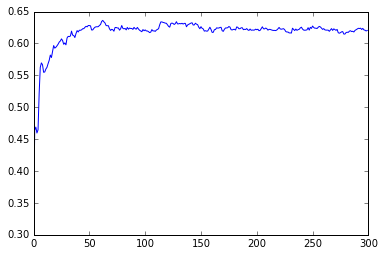

In [186]:
f1_scores = []
for i, y_pred in zip(range(1, num_estimators+1), model_ivq_adaboost.staged_predict(X_test)):
    f1_scores.append(f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None))

plt.plot(f1_scores, 'b')

#### Gradient Boosted Decision Trees

In [187]:
num_estimators = 300
model_ivq_GBC = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=300,
                                           subsample=1.0, min_samples_split=2, min_samples_leaf=1,
                                           min_weight_fraction_leaf=0.0, max_depth=3, init=None,
                                           random_state=35, max_features=None, verbose=1, max_leaf_nodes=None,
                                           warm_start=False, presort='auto')
model_ivq_GBC.fit(X_train, y_train['image_views_quantile'])

      Iter       Train Loss   Remaining Time 
         1       22342.2990           34.73m
         2       21393.6800           34.36m
         3       20694.9202           33.96m
         4       20040.5753           33.86m
         5       19479.9283           33.66m
         6       18959.9613           33.60m
         7       18553.5964           33.53m
         8       18199.7400           33.49m
         9       17879.7918           33.64m
        10       17550.2162           33.69m
        20       15620.9339           32.45m
        30       14527.6934           31.08m
        40       13805.7350           29.52m
        50       13247.1334           28.15m
        60       12841.0003           26.79m
        70       12453.0788           25.41m
        80       12133.5278           24.06m
        90       11847.3040           22.78m
       100       11561.2053           21.56m
       200        9621.7589           10.49m
       300        8253.2905            0.00s


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=35, subsample=1.0, verbose=1,
              warm_start=False)

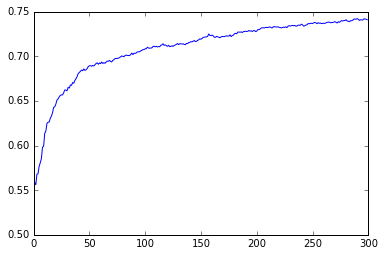

In [188]:
f1_scores = []
for i, y_pred in zip(range(1, num_estimators+1), model_ivq_GBC.staged_predict(X_test)):
    f1_scores.append(f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None))

plt.plot(f1_scores, 'b')

In [209]:
num_estimators = 300
model_ivq_GBC = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=3000,
                                           subsample=0.4, min_samples_split=10, min_samples_leaf=10,
                                           min_weight_fraction_leaf=0.0, max_depth=3, init=None,
                                           random_state=35, max_features='auto', verbose=1, max_leaf_nodes=None,
                                           warm_start=False, presort='auto')
model_ivq_GBC.fit(X_train, y_train['image_views_quantile'])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        8929.9698         692.3884          212.35m
         2        8592.0809         510.5309          210.51m
         3        8291.8852         430.0984          205.86m
         4        7987.6999         393.4292          203.44m
         5        7825.1266         301.0256          201.46m
         6        7635.4841         255.8368          200.56m
         7        7525.3905         238.5480          200.25m
         8        7283.7590         261.4463          199.92m
         9        7212.5903         178.9553          199.01m
        10        7043.4740         157.2688          198.57m
        20        6286.3965          75.9208          195.90m
        30        5873.8636          23.2486          193.16m
        40        5569.8596          17.1327          191.11m
        50        5417.7838           7.2077          189.28m
        60        5155.1465          11.4249          187.61m
       

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=10, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=3000,
              presort='auto', random_state=35, subsample=0.4, verbose=1,
              warm_start=False)

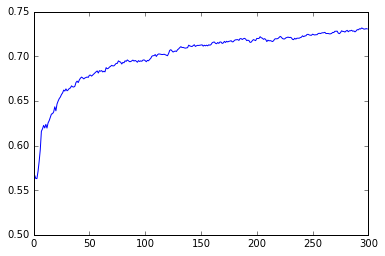

In [210]:
f1_scores = []
for i, y_pred in zip(range(1, num_estimators+1), model_ivq_GBC.staged_predict(X_test)):
    f1_scores.append(f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None))

plt.plot(f1_scores, 'b')

#### SVM

In [176]:
model_ivq_svc = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False,
                    tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1,
                    decision_function_shape=None, random_state=50)
model_ivq_svc.fit(X_train, y_train['image_views_quantile'])
y_pred = model_ivq_svc.predict(X_test)
f1_score(y_test['image_views_quantile'], y_pred, labels=None, pos_label=None, average='macro', sample_weight=None)

0.64716507056800499